Create and Art with Neural style transfer on given image using deep learning.


🖼️ Content Image (the image you want to stylize)

🎨 Style Image (the image you want to use as the artistic style)

🔄 What is Neural Style Transfer?
Neural Style Transfer uses a pretrained convolutional neural network (usually VGG19) to:

Capture content features from one image

Capture style features (textures, colors, brush strokes) from another

Generate a new image that combines both

✅ Steps Involved:
Load content and style images

Preprocess images for VGG19

Use a pretrained VGG19 model

Compute:

Content loss

Style loss (using Gram matrices)

Optimize a generated image to minimize both losses



Iteration 0: Total Loss=1337744605315072.00, Content Loss=0.00, Style Loss=1337744605315072.00
Iteration 10: Total Loss=322123386060800.00, Content Loss=4691.12, Style Loss=322123386060800.00
Iteration 20: Total Loss=183509725478912.00, Content Loss=5120.65, Style Loss=183509725478912.00
Iteration 30: Total Loss=130112343244800.00, Content Loss=5444.31, Style Loss=130112334856192.00
Iteration 40: Total Loss=96998422216704.00, Content Loss=5545.22, Style Loss=96998413828096.00
Iteration 50: Total Loss=74529502134272.00, Content Loss=5661.73, Style Loss=74529493745664.00
Iteration 60: Total Loss=58872546983936.00, Content Loss=5761.95, Style Loss=58872542789632.00
Iteration 70: Total Loss=47584370491392.00, Content Loss=5876.82, Style Loss=47584366297088.00
Iteration 80: Total Loss=39167530631168.00, Content Loss=5979.69, Style Loss=39167526436864.00
Iteration 90: Total Loss=32733736730624.00, Content Loss=6044.12, Style Loss=32733730439168.00


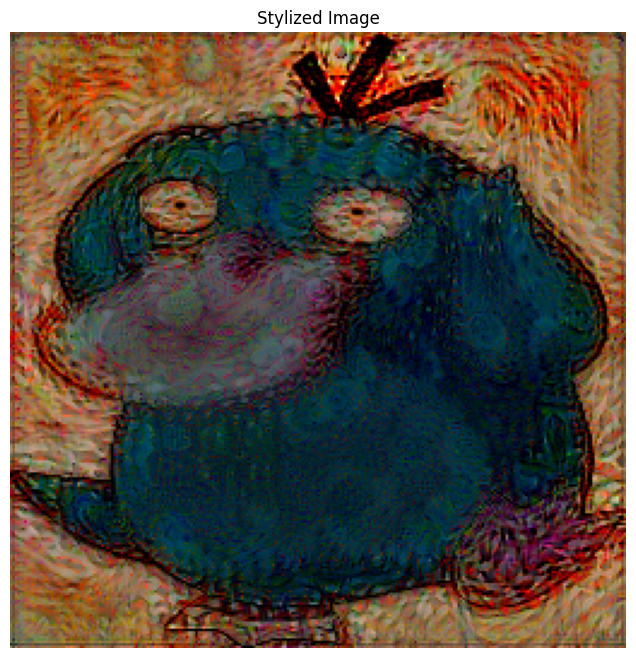

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras import models
import PIL.Image as pil_image

# Global content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Load and preprocess image
def load_img(img_path, target_size=(256, 256)):
    img = pil_image.open(img_path).convert('RGB')
    img = img.resize(target_size, pil_image.LANCZOS)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Deprocess image for viewing
def deprocess_img(img):
    img = tf.squeeze(img, axis=0)
    img = img.numpy()
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Compute Gram matrix for style features
def gram_matrix(tensor):
    x = tf.squeeze(tensor, axis=0)
    x = tf.transpose(x, (2, 0, 1))  # Channels first
    features = tf.reshape(x, (x.shape[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# Load pretrained VGG19 and extract specific layers
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in content_layers + style_layers]
    return models.Model(inputs=vgg.input, outputs=outputs)

# Compute total loss
def compute_loss(model, loss_weights, generated_image, content_targets, style_targets):
    content_weight, style_weight = loss_weights
    model_outputs = model(generated_image)

    content_output = model_outputs[:len(content_layers)]
    style_output = model_outputs[len(content_layers):]

    # Content loss
    content_loss = tf.reduce_mean((content_output[0] - content_targets[0]) ** 2)

    # Style loss using Gram matrices
    style_loss = 0
    for output, target in zip(style_output, style_targets):
        gram_o = gram_matrix(output)
        style_loss += tf.reduce_mean((gram_o - target) ** 2)
    style_loss *= style_weight / len(style_layers)

    total_loss = content_weight * content_loss + style_loss
    return total_loss, content_loss, style_loss

# Run Neural Style Transfer
def run_style_transfer(content_path, style_path, iterations=100, content_weight=1e3, style_weight=1e-2):
    content_img = preprocess_input(load_img(content_path))
    style_img = preprocess_input(load_img(style_path))
    generated_img = tf.Variable(content_img, dtype=tf.float32)

    model = get_model()
    content_features = model(content_img)[:len(content_layers)]
    style_features = [gram_matrix(f) for f in model(style_img)[len(content_layers):]]

    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    @tf.function()
    def train_step():
        with tf.GradientTape() as tape:
            loss, c_loss, s_loss = compute_loss(model, (content_weight, style_weight), generated_img, content_features, style_features)
        grad = tape.gradient(loss, generated_img)
        optimizer.apply_gradients([(grad, generated_img)])
        return loss, c_loss, s_loss

    for i in range(iterations):
        loss, c_loss, s_loss = train_step()
        if i % 10 == 0:
            print(f"Iteration {i}: Total Loss={loss:.2f}, Content Loss={c_loss:.2f}, Style Loss={s_loss:.2f}")

    return deprocess_img(generated_img)

# ---- Run Style Transfer ----
content_path = 'C.jpg'
style_path = 'S.jpg'

output = run_style_transfer(content_path, style_path, iterations=100)

# Display result
plt.figure(figsize=(8, 8))
plt.imshow(output)
plt.axis('off')
plt.title("Stylized Image")
plt.show()

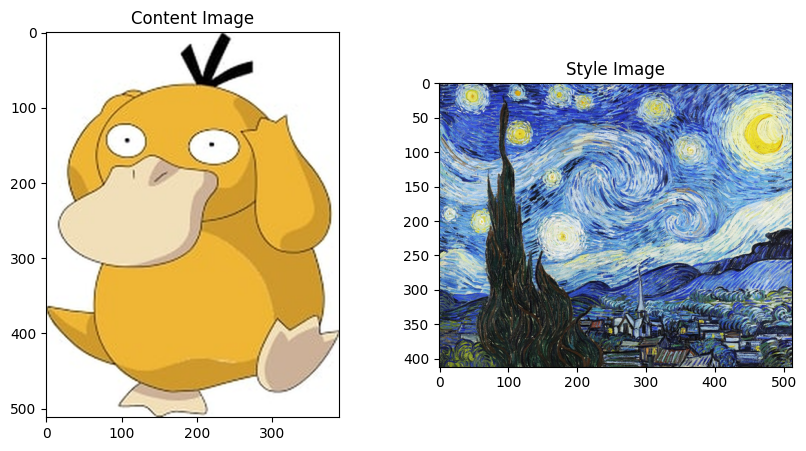

Step 1, Loss: 3434808576.0
Step 2, Loss: 2561333504.0
Step 3, Loss: 1899970304.0
Step 4, Loss: 1317377408.0
Step 5, Loss: 939286848.0
Step 6, Loss: 776388672.0
Step 7, Loss: 696557696.0
Step 8, Loss: 621784064.0
Step 9, Loss: 543155584.0
Step 10, Loss: 466847264.0


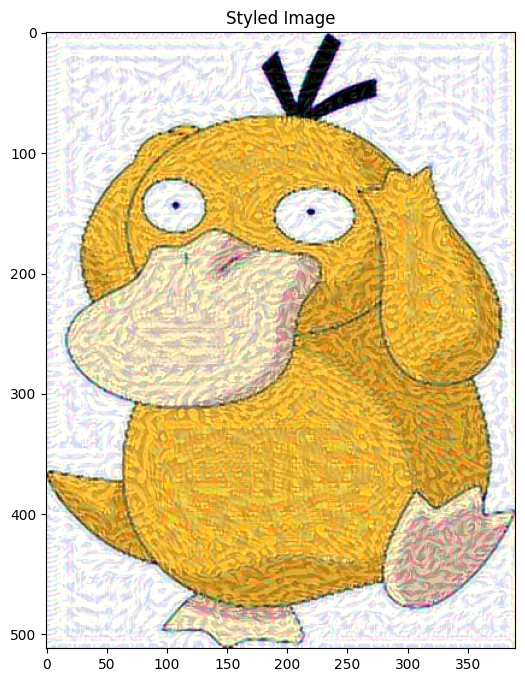

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import os

from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

# Helper function to load and preprocess images
def load_and_process_image(image_path, max_dim=512):
    img = Image.open(image_path)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize(
        (round(img.size[0] * scale), round(img.size[1] * scale)), Image.Resampling.LANCZOS
    )
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

# Helper function to deprocess images
def deprocess_image(processed_img):
    x = processed_img.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load content and style images
content_image_path = 'C.jpg'  # Replace with your content image path
style_image_path = 'S.jpg'  # Replace with your style image path
content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

# Display content and style images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Content Image")
plt.imshow(deprocess_image(content_image[0]))
plt.subplot(1, 2, 2)
plt.title("Style Image")
plt.imshow(deprocess_image(style_image[0]))
plt.show()

# Build the VGG19 model for feature extraction
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Extract features from selected layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
output_layers = style_layers + content_layers
model = Model([vgg.input], [vgg.get_layer(layer).output for layer in output_layers])

# Define the loss functions
style_weight = 1e-2
content_weight = 1e4

def gram_matrix(tensor):
    x = tf.squeeze(tensor)
    x = tf.reshape(x, [-1, x.shape[-1]])
    n = tf.shape(x)[0]
    gram = tf.matmul(x, x, transpose_a=True) / tf.cast(n, tf.float32)
    return gram

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]

    style_score = 0
    content_score = 0

    # Calculate style loss
    for target, comb in zip(gram_style_features, style_output_features):
        style_score += tf.reduce_mean(tf.square(target - gram_matrix(comb)))

    # Calculate content loss
    for target, comb in zip(content_features, content_output_features):
        content_score += tf.reduce_mean(tf.square(target - comb))

    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    return total_loss

# Prepare the style and content targets
style_features = model(style_image)[:len(style_layers)]
content_features = model(content_image)[len(style_layers):]
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

# Set up optimization
init_image = tf.Variable(content_image, dtype=tf.float32)
opt = tf.optimizers.Adam(learning_rate=5.0)

# Run the style transfer
epochs = 10  # Reduced from 1000 to 10 for faster processing
for i in range(epochs):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, (style_weight, content_weight), init_image, gram_style_features, content_features)
    grads = tape.gradient(loss, init_image)
    opt.apply_gradients([(grads, init_image)])
    if i % 1 == 0:
        print(f"Step {i+1}, Loss: {loss.numpy()}")

# Display the final result
output_image = deprocess_image(init_image.numpy()[0])
plt.figure(figsize=(8, 8))
plt.title("Styled Image")
plt.imshow(output_image)
plt.show()
